# Experimentacion

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import glob, os
import math
import random
from subprocess import Popen, PIPE
from tqdm import tqdm

In [19]:
NS_PER_SECOND = 1000000000

def getTime(s, ns):
    if (s > 0 and ns < 0):
        ns += NS_PER_SECOND
        s=s-1
    elif (s < 0 and ns > 0):
        ns -= NS_PER_SECOND
        s=s+1

    ms = ns / 1000000
    ms += s * 1000
    return ms

In [20]:
executablePath = './../codigo/build/ContarPalabras'
os.chdir("./")
print(executablePath)

./../codigo/build/ContarPalabras


### Funciones para programa con unico archivo

In [21]:
def correrExp(inputPath, outputPath):
    
    threads = [1,2,3,4,5,6,7,8,10,15,20,26]
    columns = ['cantThreads', 'sec', 'ns', 'algorithm']
    df = pd.DataFrame(columns = columns)
    dataframes = []

    for repeat in tqdm(range(20)):
        #create output file
        outputFile = open(outputPath, 'w+')
        outputFile.write("cantThreads,sec,ns,algorithm\n")

        for cantThreads in threads:
            command = executablePath + " %s %s %s" % (cantThreads, cantThreads, inputPath)
            p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
            p.wait()

            output=p.stdout.read().decode("utf-8")
            outputFile.write(output)

        outputFile.close()

        df = pd.read_csv(outputPath, header=[0])
        dataframes.append(df)

    dfExp = pd.concat(dataframes)
    dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
    dfExp = dfExp.drop(['sec', 'ns'], axis = 1)
    result = dfExp.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
    return result

def parseData(dataFrame, algorithm):
    parsedDataFrame = dataFrame
    parsedDataFrame = parsedDataFrame.loc[parsedDataFrame['algorithm'] == algorithm]
    time = parsedDataFrame['time']['mean'].values.tolist()
    std = parsedDataFrame['time']['std'].values.tolist()
    cantThreads = parsedDataFrame['cantThreads'].values.tolist()
    
    return time, std, cantThreads

### Multithreading en maximo paralelo con distintas distribuciones

100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


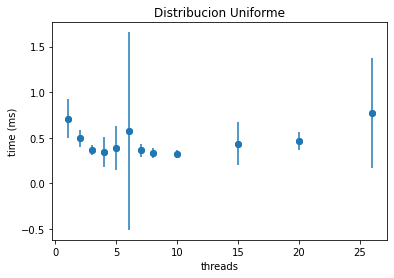

In [22]:
dfUniforme = correrExp('./data/uniformeRandomized.txt','./results/uniformeRandomized.csv')
timeUni, stdUni, cantThreadsUni = parseData(dfUniforme, 'maximoParalelo')

# grafico
plt.scatter(cantThreadsUni, timeUni)
plt.errorbar(cantThreadsUni,timeUni, yerr = stdUni, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.title('Distribucion Uniforme')

##para guardar img
imgPath="./img/mp-uniforme"
plt.savefig(imgPath)

plt.show()

100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


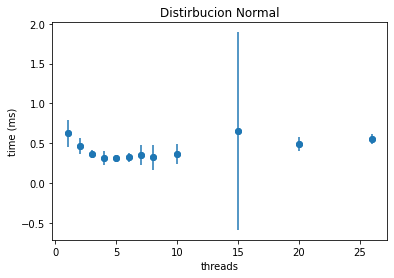

In [23]:
dfNormal = correrExp('./data/normalRandomized.txt','./results/normalRandomized.csv')
timeNorm, stdNorm, cantThreadsNorm = parseData(dfNormal, 'maximoParalelo')

# grafico
plt.scatter(cantThreadsNorm, timeNorm)
plt.errorbar(cantThreadsNorm,timeNorm, yerr = stdNorm, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.title('Distirbucion Normal')

##para guardar img
imgPath="./img/mp-normal"
plt.savefig(imgPath)

plt.show()

100%|██████████| 20/20 [01:46<00:00,  5.33s/it]


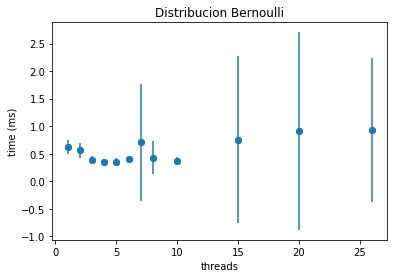

In [24]:
dfBernoulli = correrExp('./data/bernoulliRandomized.txt','./results/bernoulliRandomized.csv')
timeBer, stdBer, cantThreadsBer = parseData(dfBernoulli, 'maximoParalelo')

# grafico
plt.scatter(cantThreadsBer, timeBer)
plt.errorbar(cantThreadsBer,timeBer, yerr = stdBer, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.title('Distribucion Bernoulli')

##para guardar img
imgPath="./img/mp-bernoulli"
plt.savefig(imgPath)

plt.show()

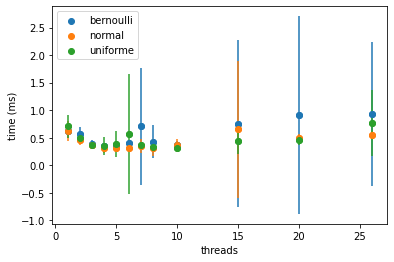

In [30]:
#IMPORTANTE: primero hay que correr *TODAS* las cells de arriba
plt.scatter(cantThreadsBer, timeBer, label = "bernoulli")
plt.errorbar(cantThreadsBer,timeBer, yerr = stdBer, fmt="o")

plt.scatter(cantThreadsNorm, timeNorm, label = "normal")
plt.errorbar(cantThreadsNorm,timeNorm, yerr = stdNorm, fmt="o")

plt.scatter(cantThreadsUni, timeUni, label = "uniforme")
plt.errorbar(cantThreadsUni,timeUni, yerr = stdUni, fmt="o")

plt.legend(loc = "upper left")
plt.xlabel('threads')
plt.ylabel('time (ms)')

##para guardar img
imgPath="./img/mp-comparison"
plt.savefig(imgPath)

plt.show()

### Multithreading en cargar multiples archivos

In [26]:
def correrExpMult(inputPath, outputPath):
    
    threads = [1,2,3,4,5,6,7,8,10,15,20,26]
    columns = ['cantThreads', 'sec', 'ns', 'algorithm']
    df = pd.DataFrame(columns = columns)
    dataframes = []
    
    for repeat in tqdm(range(10)):
        for dataset in os.listdir(inputPath):
            
            #create output file
            outputFile = open(outputPath, 'w+')
            outputFile.write("cantThreads,sec,ns,algorithm\n")

            args = ""
            for file in os.listdir(inputPath):
                args += " " + inputPath + file

            for cantThreads in threads:
                command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
                p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
                p.wait()

                output=p.stdout.read().decode("utf-8")
                outputFile.write(output)

            outputFile.close()

            df = pd.read_csv(outputPath, header=[0])
            dataframes.append(df)

    dfExp = pd.concat(dataframes)
    dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
    dfExp = dfExp.drop(['sec', 'ns'], axis = 1)
    result = dfExp.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
    return result

100%|██████████| 10/10 [01:44<00:00, 10.42s/it]


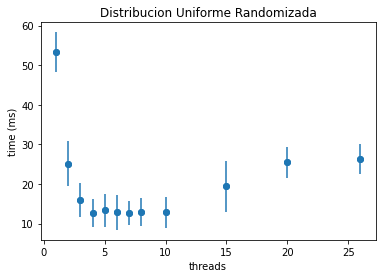

In [27]:
dfMultRand = correrExpMult('./data/incrementalRand/', './results/uniformeMultiplesArchivosRand.csv')
timeMultRand, stdMultRand, cantThreadsMultRand = parseData(dfMultRand, 'cargarMultiplesArchivos')

# grafico
plt.scatter(cantThreadsMultRand, timeMultRand)
plt.errorbar(cantThreadsMultRand,timeMultRand, yerr = stdMultRand, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.title('Distribucion Uniforme Randomizada')

##para guardar img
imgPath="./img/cma-uniforme-rand"
plt.savefig(imgPath)

plt.show()

100%|██████████| 10/10 [01:51<00:00, 11.13s/it]


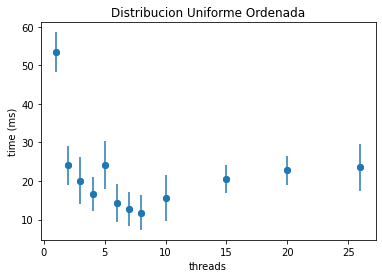

In [28]:
dfMultSort = correrExpMult('./data/incremental/', './results/uniformeMultiplesArchivosSort.csv')
timeMultSort, stdMultSort, cantThreadsMultSort = parseData(dfMultSort, 'cargarMultiplesArchivos')

# grafico
plt.scatter(cantThreadsMultSort, timeMultSort)
plt.errorbar(cantThreadsMultSort,timeMultSort, yerr = stdMultSort, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.title('Distribucion Uniforme Ordenada')

##para guardar img
imgPath="./img/cma-uniforme-sort"
plt.savefig(imgPath)

plt.show()

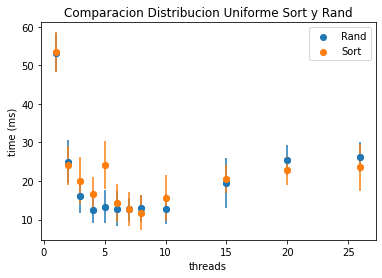

In [31]:
plt.scatter(cantThreadsMultRand, timeMultRand, label = 'Rand')
plt.errorbar(cantThreadsMultRand,timeMultRand, yerr = stdMultRand, fmt="o")

plt.scatter(cantThreadsMultSort, timeMultSort, label = 'Sort')
plt.errorbar(cantThreadsMultSort,timeMultSort, yerr = stdMultSort, fmt="o")

plt.legend(loc = "upper right")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.title('Comparacion Distribucion Uniforme Sort y Rand')

##para guardar img
imgPath="./img/cma-comparison"
plt.savefig(imgPath)

plt.show()